### Ch4_Evaluation_And_Optimization_Of_GenerativeAI_Quantization_LLM_Demo

- Quantization is the process of reducing the precision of a model’s weights and activations from floating-point numbers to lower bitwidth representations. 
-  Used to improve the model’s suitability 

#### Quantization Aware Training Bert Model

- Quantization-aware training means training the model from the start using quantized weights and activations, which can result in higher accuracy than post-training quantization.

##### Steps to perform Quantization-aware training:
- Load your data.
- Analyze and clean it.
- Using pretrained model prepare the text inputs for the model(tokenized dataset)
- Enable quantization-aware training using **model.qconfig = torch.quantization.default_qconfig**
- Use quantized model to train your model
- Evaluate model performance

1. Load the data inside `train` folder and create a single dataset representing this data.

#### 1.1 Import Libraries

In [1]:
from pathlib import Path
import pandas as pd
import torch
pd.set_option('display.max_colwidth', 1)
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_vaccine_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ['-1.0','0.0','1.0']:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            if  label_dir == "0.0":
                labels.append(0.0 )
            elif  label_dir == "-1.0":
                labels.append(-1.0)  
            else :
                labels.append(1.0)

    return texts, labels

train_texts, train_labels = read_vaccine_split('/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/train')
test_texts, test_labels = read_vaccine_split('/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/test')

In [ ]:
import awswrangler as wr

def read_vaccine_split(split_dir):
    dfs = []
    for label_dir in ['-1.0','0.0','1.0']:
        df = wr.s3.read_csv(f'{split_dir}/{label_dir}/*', header=None, sep = '\t')
        df['text'] = df[0]
        df['label'] = label_dir
        dfs.append(df[['text', 'label']])
    return wr.pandas.concat(dfs, axis=0)

df_train = read_vaccine_split('s3://course-dev-ds-workspace/genai/vaccines-sentiment-analysis/train')
df_test = read_vaccine_split('s3://course-dev-ds-workspace/genai/vaccines-sentiment-analysis/test')

In [3]:
train=pd.DataFrame(list(zip(train_texts,train_labels)),columns=["text",'label'])
test=pd.DataFrame(list(zip(test_texts,test_labels)),columns=["text",'label'])

2. Analyze the dataset:
    - What's the number of rows and columns ?
    - Is there bad data inside this dataset (null values, missing etc) ?
        - How should we deal with bad rows?
    - How is training set distributed in respect to sentiment classes (i.e. how many rows with negative sentiment etc) ?

##### Analyze your data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    7999 non-null   object 
 1   label   7999 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.1+ KB


In [5]:
train.shape

(7999, 2)

In [6]:
train.describe()

,label
count,7999.000000
mean,0.301413
std,0.646832
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
# Check for "NaN" values
train.isna().any() 

text     False
label    False
dtype: bool

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    2000 non-null   object 
 1   label   2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


In [9]:
test.shape

(2000, 2)

In [10]:
test.describe()

,label
count,2000.000000
mean,0.302000
std,0.646533
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
# Check for "NaN" values
test.isna().any() 

text     False
label    False
dtype: bool

##### to avoid target -1 out of bound we will convert -1 label to 0 and 0 to 1 and 1 to 2

In [12]:
def to_sentiment(label):
    label = int(label)
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:
        return 2


In [13]:
#convert to float to int to avoid tensor error target size doesnot match input size 
train['label']=train['label'].astype(int)
train['sentiment'] = train.label.apply(to_sentiment)
train=train.drop(columns='label')
train['label']=train['sentiment']
train=train.drop(columns='sentiment')

In [14]:
train.head(2)

,text,label
0,url dr reveals truth about vaccines,0
1,parenting or bio terrorism as usual its too close to call i dont vaccinate my child because via user url,0


In [15]:
test['label']=test['label'].astype(int)
test['sentiment'] = test.label.apply(to_sentiment)
test=test.drop(columns='label')
test['label']=test['sentiment']
test=test.drop(columns='sentiment')

In [16]:
test.head(2)

,text,label
0,user politicians are weighing in on the measles vaccine debate but should they url dont encourage them,0
1,user i would be very interested in hearing your opinion after i know you have educated yourself on vaccination poisoning and autism,0


In [17]:
df=train.append(test)

/var/folders/jh/0vc4j76j79g_1kb570k87_4h0000gn/T/ipykernel_1907/204322198.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=train.append(test)


Text(0.5, 0, 'review sentiment')

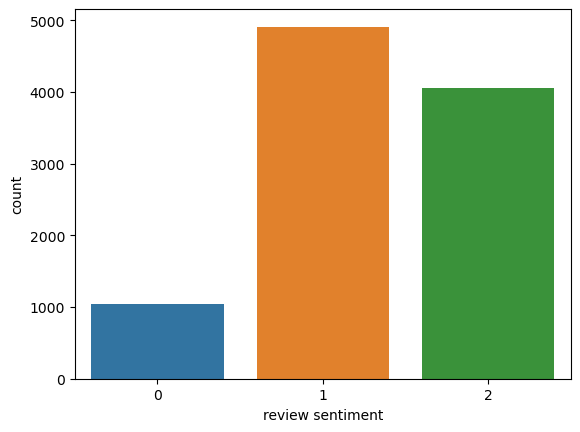

In [18]:
sns.countplot(x=df["label"])
plt.xlabel('review sentiment')

In [19]:
#Convert dataframe to dataset to give input to model
from datasets import Dataset
dataset = Dataset.from_pandas(df)
train_data=Dataset.from_pandas(train)
test_data=Dataset.from_pandas(test)

In [20]:
small_train_dataset = train_data.shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = test_data.shuffle(seed=42).select([i for i in list(range(300))])


In [21]:
print(f"Number of training examples: {len(train)}")
#print(f"Number of validation examples: {len(val)}")
print(f"Number of testing examples: {len(test)}")

Number of training examples: 7999
Number of testing examples: 2000


3. You are going to use this dataset to build a sentiment classification model. Using BERT-312 to encode the data, build a model.

#### Initiate the distilbert tokenizer and model

In [22]:
# Initiate the distilbert tokenizer and model
from transformers import AutoTokenizer,AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

#### Preprocess The Data

In [23]:
# prepare the text inputs for the model for both splits of our dataset (training and test) by using the map method:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
 
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [24]:
#check the training dataset
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3000
})

In [25]:
#Cross check encoded input using tokenizer.decode()
for i in tokenized_train['input_ids']: 
    print(tokenizer.decode(i))

2023-08-21 09:26:42.527867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CLS] rotavirus vaccine greatly reduced gastroenteritis hospitalizations in children url [SEP]
[CLS] user i didnt want to risk getting a disease im not yet vaccinated for [SEP]
[CLS] this is what happens when babies arent vacinated vacinate measles url [SEP]
[CLS] user we have been finding over the last 5 years that it is this combination of headneck injury vaccinesworst case scenario of asd [SEP]
[CLS] url battling infectious diseases in the 20th century the impact of vaccines [SEP]
[CLS] user user user my boys are nnoott vaccinated that was battle royale with all 17 schools just my boys attended [SEP]
[CLS] the fact that vaccinations are mandatory for school nshit makes me not trust it [SEP]
[CLS] its 2015 and our president has to tell parents to vaccinate their children pro life let these dumbasses reproduce [SEP]
[CLS] user wow theyre better off reading about autism on wikipedia than calling off all immunizations and endangering their kids [SEP]
[CLS] cheers mistersoftee milkshakes

[CLS] i know this may come as a shock but a new study places blame for disneyland measles outbreak on antivaxers url [SEP]
[CLS] shocking user longterm disease database proves the value of vaccines url [SEP]
[CLS] this is my vaccineinjured daughter lost in all of the recent stories about a spike in measles cases are many url [SEP]
[CLS] user mall shoppers in th nyc suburbs may have been exposed to measles health officials say url perils of not vacc [SEP]
[CLS] great job andrew wakefieldcongratulations on keeping children away from the happiest place on earth vaccinesdonotcauseautism science [SEP]
[CLS] studies show that more children are afflicted w self entitlement than side effects from vaccinations amp parents are main cause vaccinations [SEP]
[CLS] user gop stop blaming immigrants first ebola now measles which diseasesbrought their ancestors ainf url [SEP]
[CLS] user gop stop blaming immigrants first ebola now measles which diseasesbrought their ancestors ainf url [SEP]
[CLS] user 

In [26]:
#To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors 
#and concatenate them with the correct amount of padding:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


#### Define compute_metrics Function to Evaluate the model:

In [28]:
import numpy as np
from datasets import load_metric
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}


#### Quantize the model before training the data

In [28]:
import torch.quantization
# Enable quantization-aware training
model.qconfig = torch.quantization.default_qconfig

In [29]:
# Convert the model to quantized version
quantized_model = torch.quantization.convert(model, inplace=False)


In [33]:
#define the training arguments and define a Trainer with quantized model
from transformers import Trainer,TrainingArguments


training_args = TrainingArguments(
   output_dir="./DistilBert_results_quantize",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   
)
trainer = Trainer(
   model=quantized_model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

##### Train the model

In [34]:

trainer.train()

/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.48543313209046707, metrics={'train_runtime': 2451.0104, 'train_samples_per_second': 2.448, 'train_steps_per_second': 0.153, 'total_flos': 50942902473792.0, 'train_loss': 0.48543313209046707, 'epoch': 2.0})

##### Evaluate the model

In [36]:
#Quantization Aware evaluation
trainer.evaluate()

{'eval_loss': 0.6434703469276428,
 'eval_precision': 0.7533333333333333,
 'eval_recall': 0.7533333333333333,
 'eval_f1': 0.7533333333333333,
 'eval_accuracy': 0.7533333333333333,
 'eval_runtime': 103.429,
 'eval_samples_per_second': 2.901,
 'eval_steps_per_second': 0.184,
 'epoch': 2.0}

#### This is evalution without quantization from ch3 exercise1

In [42]:
import numpy as np
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/var/folders/jh/0vc4j76j79g_1kb570k87_4h0000gn/T/ipykernel_840/3091709965.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("precision")


{'eval_loss': 1.0823156833648682,
 'eval_precision': 0.5,
 'eval_recall': 0.5,
 'eval_f1': 0.5,
 'eval_accuracy': 0.5,
 'eval_runtime': 13.1802,
 'eval_samples_per_second': 22.761,
 'eval_steps_per_second': 1.442}

#### Save the trained model in output_dir folder which is created locally

In [37]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './DistilBert_results_quantize'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./DistilBert_results_quantize


('./DistilBert_results_quantize/tokenizer_config.json',
 './DistilBert_results_quantize/special_tokens_map.json',
 './DistilBert_results_quantize/vocab.txt',
 './DistilBert_results_quantize/added_tokens.json',
 './DistilBert_results_quantize/tokenizer.json')

4. Using `test` folder, evaluate the performance of your sentiment analysis model.
    - Are there subsets of dataset where your model performs better or worse ? If so, why and how to fix ?

#### Use your trained model to predict your response.

In [38]:
#Use your train model to get labela for sample data
tokenizer = AutoTokenizer.from_pretrained(output_dir,ignore_mismatched_sizes=True)
model = AutoModelForSequenceClassification.from_pretrained(output_dir,ignore_mismatched_sizes=True,id2label={0: 'Negative', 1: 'Neutral',2:'Positive'})

In [39]:
sampleText="user user  amp 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately"
inputs = tokenizer(sampleText, return_tensors="pt")
outputs = model(**inputs)

In [40]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0892,  0.0206, -0.0710]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [41]:
#use pipeline to view sentiments for sample data
from transformers import pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = sampleText
results = nlp(sentences)
print(results)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'Negative', 'score': 0.3589809536933899}]


In [51]:
sol= pd.read_csv("/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/submission.csv")

In [52]:
sol['filename']='/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/'+sol['tweet_id'].astype('str')+'.txt'
sol.head()

,tweet_id,filename
0,00BHHHP1,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/00BHHHP1.txt
1,00UNMD0E,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/00UNMD0E.txt
2,01AXPTJF,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/01AXPTJF.txt
3,01HOEQJW,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/01HOEQJW.txt
4,01JUKMAO,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/01JUKMAO.txt


In [53]:
sentences=[]
for i in sol.filename:
    sentence = open(i).read()
    sentences.append(sentence)

In [54]:
sol1=pd.DataFrame({'Sentence':sentences})
sol=sol.join(sol1)
sol.head(2)

,tweet_id,filename,Sentence
0,00BHHHP1,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/00BHHHP1.txt,user user amp 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately
1,00UNMD0E,/Users/kirtikamerkar/Austincapitaldata/GenerativeAI_specterDefence/vaccines-sentiment-analysis/sol/00UNMD0E.txt,students starting school without whooping cough vaccinations url scpick


In [55]:
sol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  5177 non-null   object
 1   filename  5177 non-null   object
 2   Sentence  5177 non-null   object
dtypes: object(3)
memory usage: 121.5+ KB


In [47]:
sol=sol.head(50)
sentences=sol.Sentence.tolist()
results=[]
for sentence in sentences:
    results = nlp(sentences)
    results.append(results)

In [48]:
#predicted label with score which is The corresponding probability
results

[{'label': 'Negative', 'score': 0.3589809536933899},
 {'label': 'Negative', 'score': 0.35252219438552856},
 {'label': 'Negative', 'score': 0.3478567898273468},
 {'label': 'Negative', 'score': 0.3614078760147095},
 {'label': 'Negative', 'score': 0.34945300221443176},
 {'label': 'Negative', 'score': 0.34866777062416077},
 {'label': 'Negative', 'score': 0.3556692898273468},
 {'label': 'Negative', 'score': 0.3640626072883606},
 {'label': 'Negative', 'score': 0.3571264147758484},
 {'label': 'Negative', 'score': 0.3505041301250458},
 {'label': 'Negative', 'score': 0.35419726371765137},
 {'label': 'Neutral', 'score': 0.35348621010780334},
 {'label': 'Negative', 'score': 0.3583352565765381},
 {'label': 'Negative', 'score': 0.35834935307502747},
 {'label': 'Negative', 'score': 0.35777974128723145},
 {'label': 'Negative', 'score': 0.35294023156166077},
 {'label': 'Negative', 'score': 0.35656821727752686},
 {'label': 'Negative', 'score': 0.359342485666275},
 {'label': 'Negative', 'score': 0.36331

In [33]:
del model

#### Post Training Quanization:

- After training is complete, post-training quantization entails transforming a pre-trained model to a lower-precision integer representation.

Steps:
- First train your model 
- Now convert your model to quantized model 
- Save it and evaluate your response.

In [34]:
import torch.quantization

# Load the saved model
output_dir = './DistilBert_results'

#Use your train model to get labela for sample data
tokenizer = AutoTokenizer.from_pretrained(output_dir,ignore_mismatched_sizes=True)
model = AutoModelForSequenceClassification.from_pretrained(output_dir,ignore_mismatched_sizes=True,id2label={0: 'Negative', 1: 'Neutral',2:'Positive'})

# Set the model to evaluation mode
model.eval()

# Convert the model to quantized version
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the model
torch.save(quantized_model, 'vaccine_DistilBert_model_quantized2')

In [36]:
print(model.get_memory_footprint())

267827212


In [41]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [35]:
print(quantized_model.get_memory_footprint())

95420416


In [48]:
print(quantized_model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (k_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (v_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (out_lin): DynamicQuantizedLinear(in_features=768, out_features=768,

In [30]:
sampleText="user user  amp 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately"
inputs = tokenizer(sampleText, return_tensors="pt")
outputs = model(**inputs)

In [31]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0997, -0.4493,  0.3173]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [32]:
sampleText="user user  amp 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately"
inputs = tokenizer(sampleText, return_tensors="pt")
outputs = quantized_model (**inputs)

In [33]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0407, -0.3469,  0.2636]]), hidden_states=None, attentions=None)

In [56]:
#use pipeline to view sentiments for sample data
from transformers import pipeline
nlp_q = pipeline("sentiment-analysis", model=quantized_model, tokenizer=tokenizer)

sentences = sampleText
results = nlp_q(sentences)
print(results)

[{'label': 'Positive', 'score': 0.4384365677833557}]


In [57]:
sol=sol.head(50)
sentences=sol.Sentence.tolist()
results=[]
for sentence in sentences:
    results = nlp_q(sentences)
    results.append(results)

In [58]:
results

[{'label': 'Positive', 'score': 0.4384365677833557},
 {'label': 'Positive', 'score': 0.5660520792007446},
 {'label': 'Neutral', 'score': 0.9392682909965515},
 {'label': 'Positive', 'score': 0.6151534914970398},
 {'label': 'Neutral', 'score': 0.7860416173934937},
 {'label': 'Positive', 'score': 0.6006776690483093},
 {'label': 'Neutral', 'score': 0.8068786263465881},
 {'label': 'Neutral', 'score': 0.5748642086982727},
 {'label': 'Positive', 'score': 0.502465546131134},
 {'label': 'Neutral', 'score': 0.917319118976593},
 {'label': 'Neutral', 'score': 0.6674340963363647},
 {'label': 'Positive', 'score': 0.5584325194358826},
 {'label': 'Neutral', 'score': 0.517059862613678},
 {'label': 'Neutral', 'score': 0.947163999080658},
 {'label': 'Neutral', 'score': 0.4558921456336975},
 {'label': 'Neutral', 'score': 0.48607271909713745},
 {'label': 'Positive', 'score': 0.5571004748344421},
 {'label': 'Positive', 'score': 0.7826058864593506},
 {'label': 'Positive', 'score': 0.6432093977928162},
 {'lab